In [79]:
import requests
import numpy as np
import datetime as dt
import pandas as pd
import json
import time
import os
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator
import matplotlib.dates as mdates
from secret import WORK, HOME
%matplotlib inline

In [80]:
# Load Data
with open("traffic_2016.json") as f:
    data = [json.loads(line) for line in f.readlines()]
    df = pd.DataFrame(data)
df.index = [pd.to_datetime(date) for date in df['datetime']]
df.datetime = df.index
df['time_in_traffic'] = pd.TimedeltaIndex(df.duration_in_traffic, unit='s')

In [82]:
# Annotate routes
work_home = {WORK: "Work", HOME: "Home"}
df['origin'] = df.start_address_query.map(lambda x:work_home[x])
df['destination'] = df.end_address_query.map(lambda x:work_home[x])

In [83]:
# Get rid of columns we dont need
df = df.loc[:,~df.columns.isin({'end_address', 'end_address_query', 'start_address', 'start_address_query', 'waypoints', 'polyline'})]
df.head(4)

,datetime,distance,duration,duration_in_traffic,summary,time_in_traffic,origin,destination
2016-05-25 12:33:30.720266,2016-05-25 12:33:30.720266,27855,1287,1327,I-5 N,00:22:07,Home,Work
2016-05-25 12:33:31.946701,2016-05-25 12:33:31.946701,27838,1345,1346,I-5 S,00:22:26,Work,Home
2016-05-25 12:37:35.106617,2016-05-25 12:37:35.106617,27855,1287,1354,I-5 N,00:22:34,Home,Work
2016-05-25 12:37:36.352709,2016-05-25 12:37:36.352709,27838,1345,1377,I-5 S,00:22:57,Work,Home


In [84]:
#%% Within each route: Resample to every 4 minutes. Interpolate missing values
new_df = pd.DataFrame()
labels = []
for label, route_df in df.groupby('origin'):
    labels.append(label)
    ts = pd.Series(route_df.duration_in_traffic, index=route_df.index)
    ts = ts.resample('4T').mean()
    ts = ts.interpolate(method='time')
    new_df=new_df.append(ts)
new_df=new_df.T
new_df.dropna(inplace=True)
index=pd.MultiIndex.from_product([new_df.index, labels])
s = pd.Series(new_df.values.reshape(len(index)), index=index)

In [86]:
s.head(4)

2016-05-25 12:32:00  Home    1327.0
                     Work    1346.0
2016-05-25 12:36:00  Home    1354.0
                     Work    1377.0
dtype: float64

In [87]:
# add more columns we need
df = s.to_frame("duration_in_traffic")
df["hour"] = df.index.get_level_values(0).hour
df["dayofweek"] = df.index.get_level_values(0).dayofweek
dd = {0:"Mon", 1:"Tues", 2:"Wed", 3:"Thurs", 4:"Fri", 5:"Sat", 6:"Sun"}
df['dayofweekname'] = [dd[x] for x in df.dayofweek]
df["week"] = df.index.get_level_values(0).week
df['time'] = df.index.get_level_values(0).time
df['time_float'] = [x.hour+(x.minute/60) for x in df.time]
df['time_in_traffic'] = pd.TimedeltaIndex(df.duration_in_traffic, unit='s')
df['duration_in_traffic_min'] = df.duration_in_traffic/60

In [88]:
# strip off first and last week (for my data, ymmv)
df = df[~df.week.isin([21,32])]

In [89]:
df.head(4)

duration_in_traffic  hour  dayofweek dayofweekname  \
2016-05-30 00:00:00 Home               1205.0     0          0           Mon   
                    Work               1258.0     0          0           Mon   
2016-05-30 00:04:00 Home               1208.0     0          0           Mon   
                    Work               1265.0     0          0           Mon   

                          week      time  time_float  time_in_traffic  \
2016-05-30 00:00:00 Home    22  00:00:00    0.000000         00:20:05   
                    Work    22  00:00:00    0.000000         00:20:58   
2016-05-30 00:04:00 Home    22  00:04:00    0.066667         00:20:08   
                    Work    22  00:04:00    0.066667         00:21:05   

                          duration_in_traffic_min  
2016-05-30 00:00:00 Home                20.083333  
                    Work                20.966667  
2016-05-30 00:04:00 Home                20.133333  
                    Work                21.083333

[None, None, None, None, None, None, None]

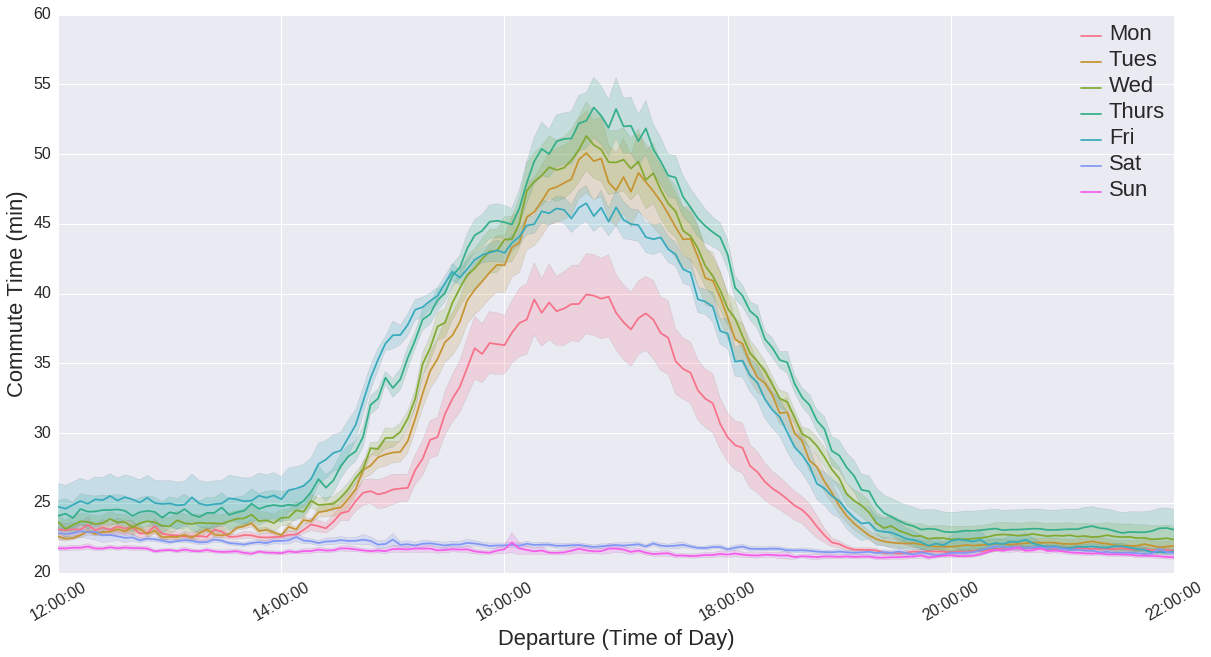

In [90]:
#%% plot by day of week
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

sns.set(style="darkgrid")
# Plot the response with standard error
sub_df = df.xs("Work", level=1)
fig, ax = plt.subplots(figsize=(20, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
ts = sns.tsplot(data=sub_df, time='time_float', unit="week", condition="dayofweekname", 
           value="duration_in_traffic_min")
ts.set_xlabel("Departure (Time of Day)",fontsize=22)
ts.set_ylabel("Commute Time (min)",fontsize=22)

ax.set_xticks(list(range(0,25,2)))
fig.canvas.draw()
xlabels = [x.get_text() for x in ax.xaxis.get_majorticklabels()]
xlabels = [str(dt.timedelta(hours=float(x))) if x else '' for x in xlabels]
ax.xaxis.set_ticklabels(xlabels)

plt.setp(ax.get_yticklabels(), fontsize=16)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=16)
ax.set_xlim(12,22)

legend = ax.get_legend()
legend.set_title("")
plt.setp(ax.get_legend().get_texts(), fontsize='22')

[None, None, None, None, None, None, None]

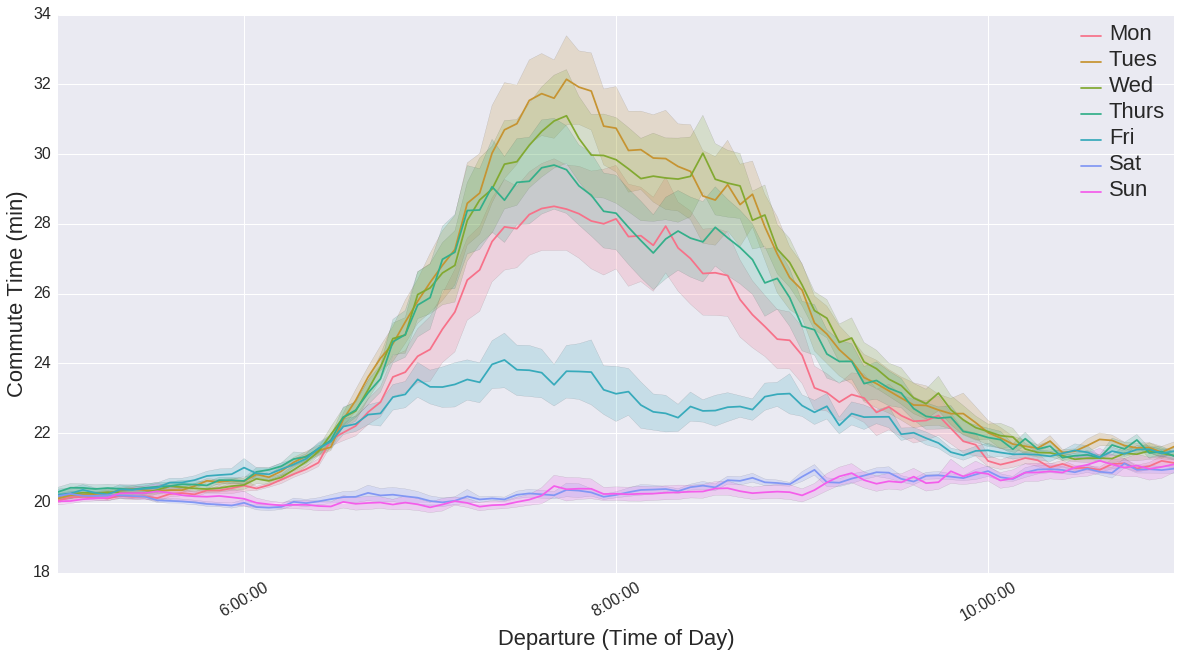

In [91]:
#%% plot by day of week
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

sns.set(style="darkgrid")
# Plot the response with standard error
sub_df = df.xs("Home", level=1)
fig, ax = plt.subplots(figsize=(20, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
ts = sns.tsplot(data=sub_df, time='time_float', unit="week", condition="dayofweekname", 
           value="duration_in_traffic_min")
ts.set_xlabel("Departure (Time of Day)",fontsize=22)
ts.set_ylabel("Commute Time (min)",fontsize=22)

ax.set_xticks(list(range(0,25,2)))
fig.canvas.draw()
xlabels = [x.get_text() for x in ax.xaxis.get_majorticklabels()]
xlabels = [str(dt.timedelta(hours=float(x))) if x else '' for x in xlabels]
ax.xaxis.set_ticklabels(xlabels)

plt.setp(ax.get_yticklabels(), fontsize=16)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=16)
ax.set_xlim(5,11)

legend = ax.get_legend()
legend.set_title("")
plt.setp(ax.get_legend().get_texts(), fontsize='22')

In [92]:
sub_df.groupby("dayofweekname").count().duration_in_traffic

dayofweekname
Fri      3600
Mon      3600
Sat      3600
Sun      3600
Thurs    3600
Tues     3600
Wed      3600
Name: duration_in_traffic, dtype: int64

In [93]:
sub_df.index[0], sub_df.index[-1]

(Timestamp('2016-05-30 00:00:00', freq='4T'),
 Timestamp('2016-08-07 23:56:00', freq='4T'))

In [94]:
set(sub_df.week)

{22, 23, 24, 25, 26, 27, 28, 29, 30, 31}